# Libraries and Settings

In [241]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Import Data

In [242]:
raw = pd.read_csv('../data/State_Zri_AllHomesPlusMultifamily.csv')
data = raw.drop(['RegionID','SizeRank'],axis=1).set_index('RegionName').T
data.index = pd.to_datetime(data.index)
data = data['2012':'2019']
drop_states = data.columns[data.isnull().sum()/data.shape[1] > 0.05]

In [243]:
data.head()

RegionName,California,Texas,New York,Florida,Illinois,Pennsylvania,Ohio,Michigan,Georgia,North Carolina,...,New Hampshire,Rhode Island,Montana,Delaware,South Dakota,Alaska,North Dakota,Vermont,District of Columbia,Wyoming
2012-01-01,1967.0,1046.0,1605.0,1303.0,1357.0,1103.0,891.0,951.0,1040.0,956.0,...,1251.0,1084.0,1002.0,1170.0,830.0,1399.0,NaN,NaN,2075.0,NaN
2012-02-01,1965.0,1044.0,1607.0,1303.0,1353.0,1104.0,891.0,941.0,1038.0,958.0,...,1253.0,1081.0,985.0,1173.0,813.0,1402.0,NaN,NaN,2079.0,NaN
2012-03-01,1962.0,1045.0,1613.0,1304.0,1351.0,1110.0,893.0,937.0,1036.0,958.0,...,1252.0,1089.0,972.0,1169.0,791.0,1404.0,831.0,NaN,2089.0,NaN
2012-04-01,1962.0,1044.0,1620.0,1307.0,1348.0,1119.0,891.0,940.0,1033.0,959.0,...,1254.0,1099.0,960.0,1162.0,777.0,1412.0,842.0,NaN,2102.0,NaN
2012-05-01,1965.0,1047.0,1630.0,1312.0,1351.0,1130.0,888.0,946.0,1033.0,961.0,...,1261.0,1113.0,957.0,1155.0,768.0,1421.0,853.0,NaN,2112.0,NaN


In [7]:
data = data.drop(drop_states,axis=1)

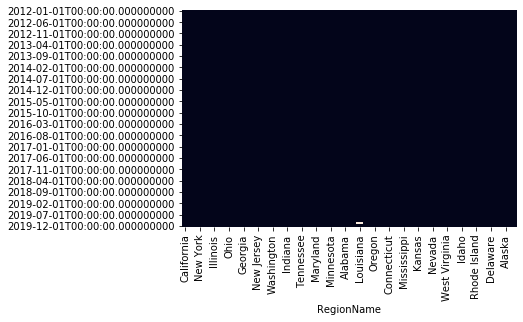

In [8]:
sns.heatmap(data.isnull(), cbar=False)

# Time Series Analysis

## ZRI vs Time for all states

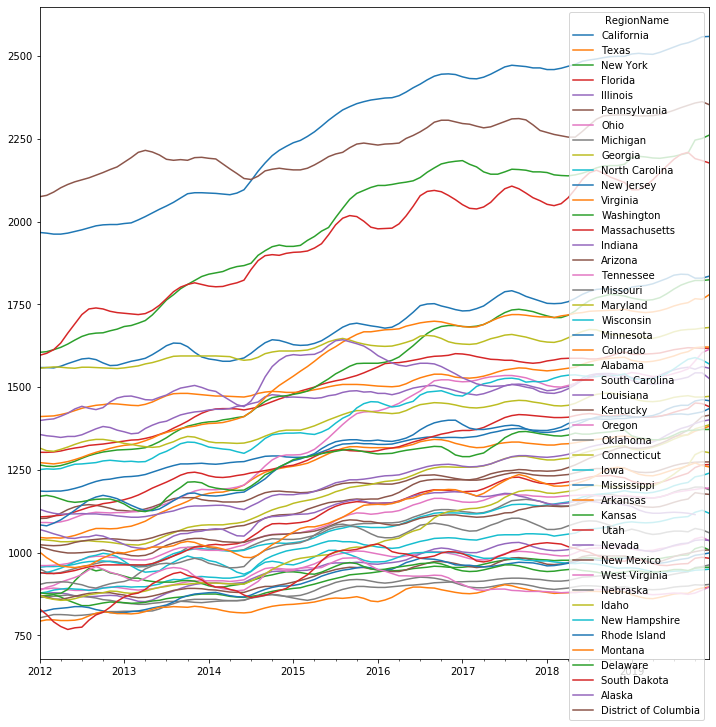

In [9]:
data.plot(figsize=(12,12))

## Time Series Analysis for a Single State

### ZRI vs Time

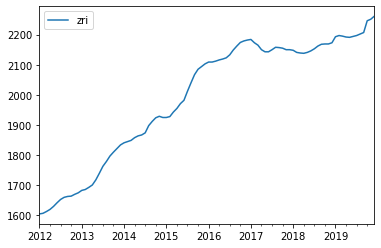

In [119]:
name = 'New York'
state = data[[name]].copy()
state.columns = ['zri']
state.plot()

## Monthly Trend

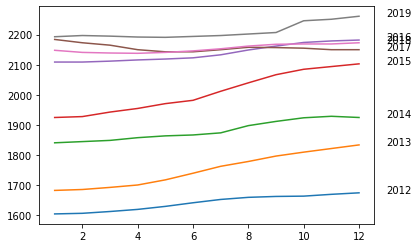

In [120]:
state['year'] = state.index.year
state['month'] = state.index.month
for y in range(2012,2020):
    plt.plot('month','zri',data = state.loc[state['year'] == y,:])
    plt.text(state.loc[state.year==y, :].shape[0]+1, state.loc[state.year==y, 'zri'][-1:].values[0], y)

## Seasonal Decompose

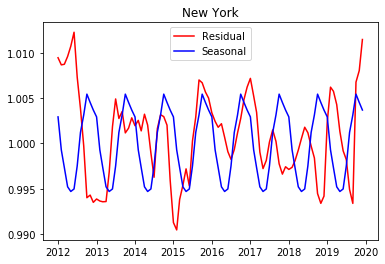

In [121]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(state['zri'], model='multiplicative', extrapolate_trend='freq')
plt.plot(decomp.resid,color='r',label='Residual')
plt.plot(decomp.seasonal,color='b',label='Seasonal')
plt.title(name)
plt.legend()

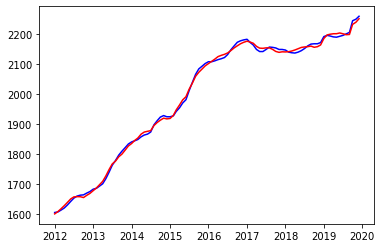

In [122]:
plt.plot(state['zri'],color='b',label='Original')
plt.plot(state['zri']/decomp.seasonal,color='r',label='Deseasonalized')

## Autocorrelation Plot

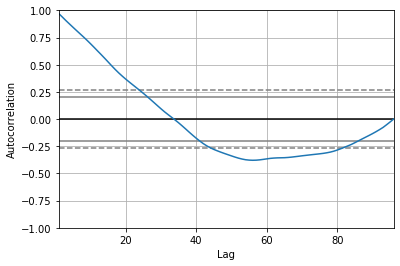

In [123]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(state['zri'])

## Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)

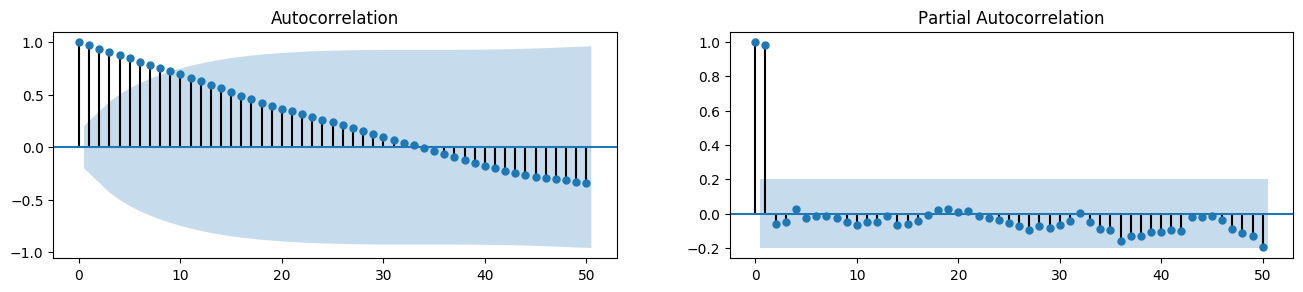

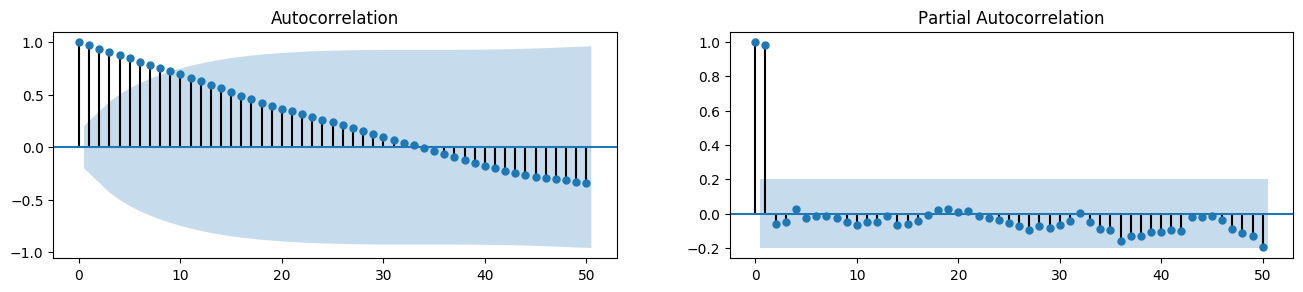

In [124]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(state['zri'], lags=50, ax=axes[0])
plot_pacf(state['zri'], lags=50, ax=axes[1])

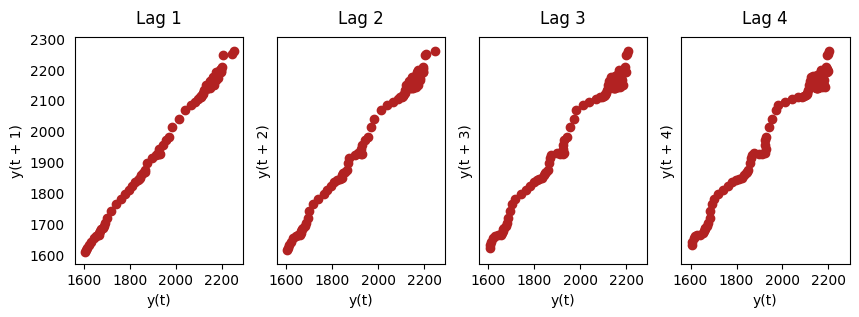

In [125]:
from pandas.plotting import lag_plot
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(state['zri'], lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

## Lag Plots

In [100]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(state.zri, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.923125249585379
p-value: 0.3212616763776307
Critial Values:
   1%, -3.503514579651927
Critial Values:
   5%, -2.893507960466837
Critial Values:
   10%, -2.583823615311909


## Granger Causality

In [131]:
from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(state[['zri', 'year']], maxlag=2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0169  , p=0.3159  , df_denom=92, df_num=1
ssr based chi2 test:   chi2=1.0500  , p=0.3055  , df=1
likelihood ratio test: chi2=1.0443  , p=0.3068  , df=1
parameter F test:         F=1.0169  , p=0.3159  , df_denom=92, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.4411  , p=0.0145  , df_denom=89, df_num=2
ssr based chi2 test:   chi2=9.3813  , p=0.0092  , df=2
likelihood ratio test: chi2=8.9421  , p=0.0114  , df=2
parameter F test:         F=4.4411  , p=0.0145  , df_denom=89, df_num=2


{1: ({'ssr_ftest': (1.0168867630097047, 0.31590349495052955, 92.0, 1),
   'ssr_chi2test': (1.0500461139774124, 0.3054964666386232, 1),
   'lrtest': (1.044285383189731, 0.3068268954036053, 1),
   'params_ftest': (1.0168867630091507, 0.31590349495066217, 92.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (4.441123744241111, 0.014505419421615658, 89.0, 2),
   'ssr_chi2test': (9.38125015637448, 0.009180945553465089, 2),
   'lrtest': (8.942110043593061, 0.011435245051369388, 2),
   'params_ftest': (4.4411237442386104, 0.014505419421648603, 89.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])])}

## Order of Differencing

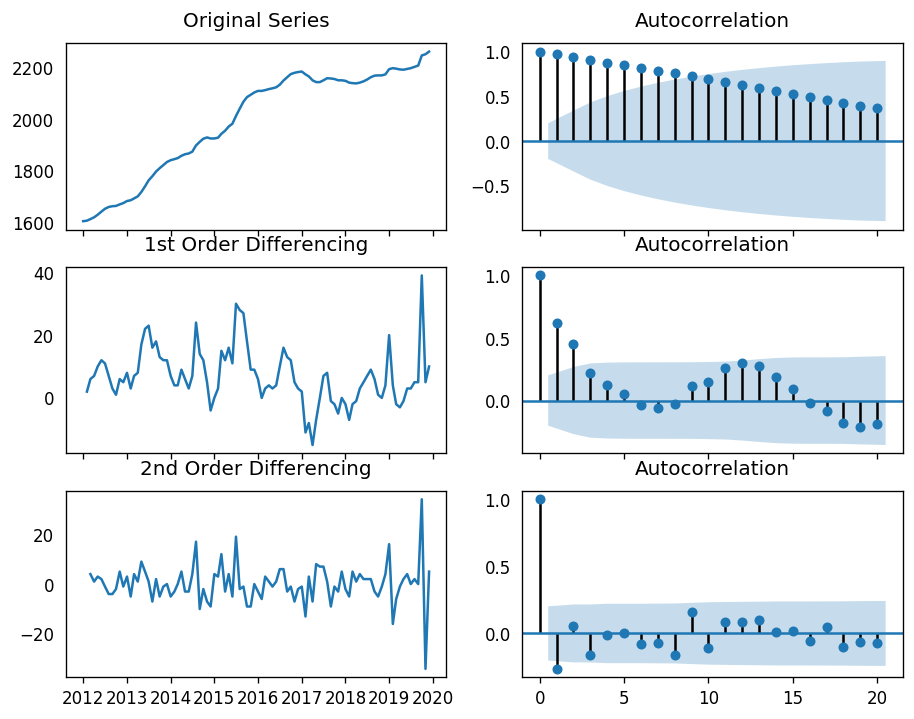

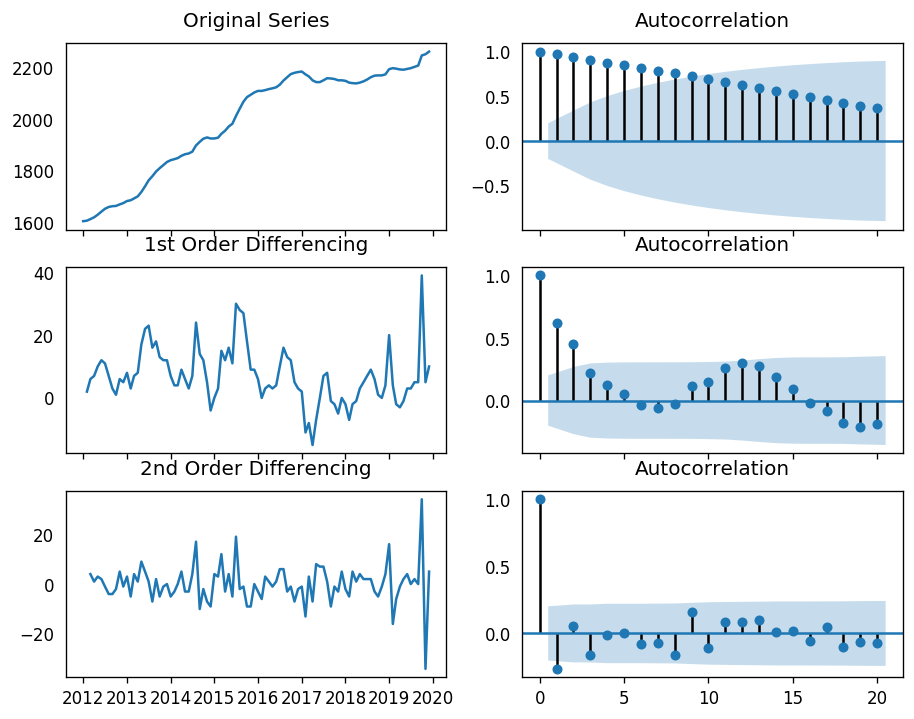

In [149]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2,sharex='col')
axes[0, 0].plot(state['zri']); axes[0, 0].set_title('Original Series')
plot_acf(state['zri'], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(state['zri'].diff().dropna()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(state['zri'].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(state['zri'].diff().diff().dropna()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(state['zri'].diff().diff().dropna(), ax=axes[2, 1])

Use 1st order, 2nd order goes to significant negative at lag=1. d = 1.

##  Order of the AR Term

In [172]:
# from pmdarima.arima.utils import ndiffs
# ndiffs(state['zri'], test='adf')  # 2

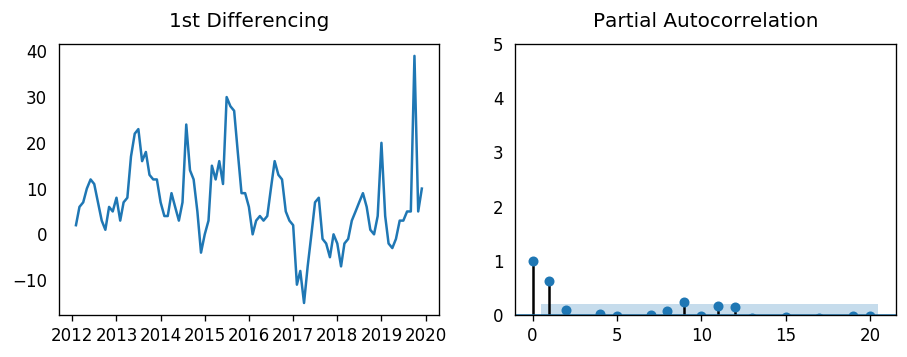

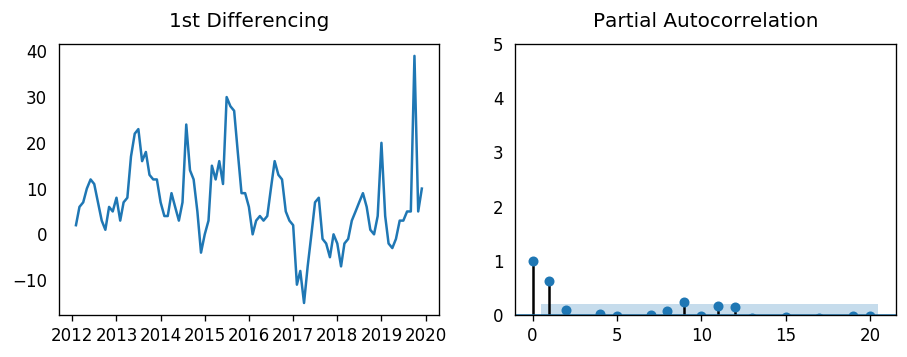

In [174]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(state['zri'].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(state['zri'].diff().dropna(), ax=axes[1])

p = 1

## Order of the MA Term

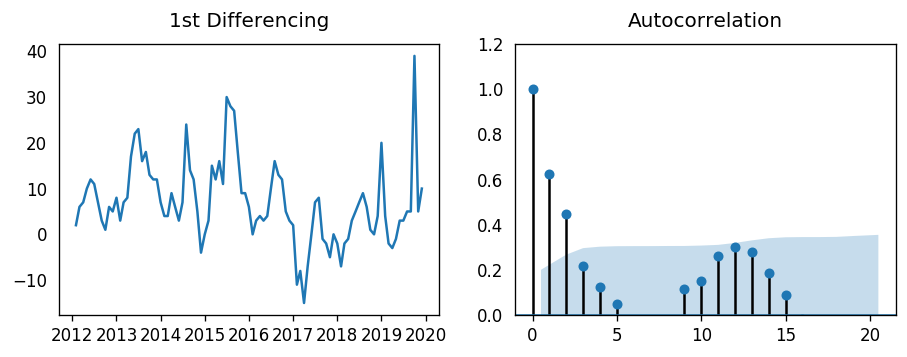

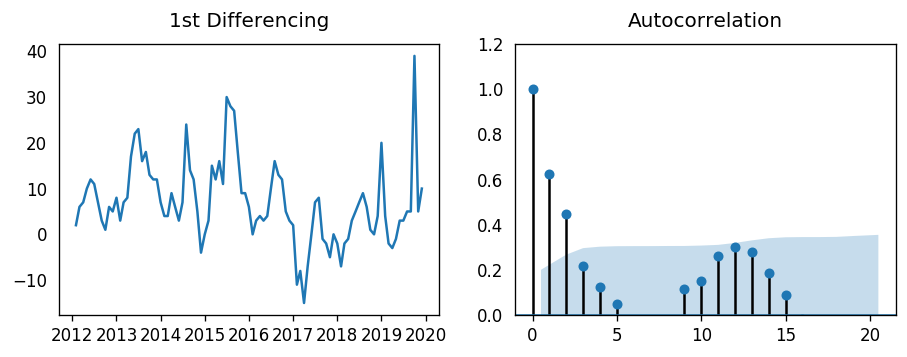

In [175]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(state['zri'].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(state['zri'].diff().dropna(), ax=axes[1])


q = 2.

## Fit ARIMA Model

In [185]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(decomp.trend, order=(1,1,1),freq='MS')
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.trend   No. Observations:                   95
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -174.703
Method:                       css-mle   S.D. of innovations              1.504
Date:                Sun, 22 Mar 2020   AIC                            357.407
Time:                        11:24:33   BIC                            367.622
Sample:                    02-01-2012   HQIC                           361.535
                         - 12-01-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             6.6971      2.602      2.574      0.010       1.597      11.797
ar.L1.D.trend     0.9597      0.025     37.711      0.000       0.910       1.010
ma.L1.D.trend    -0.1690      0.094     

In the original data, why is ar1 0.239? Why is ma1 0.082? Both too big!
decomp.trend is much better! And 1,1,0 should be sufficient!

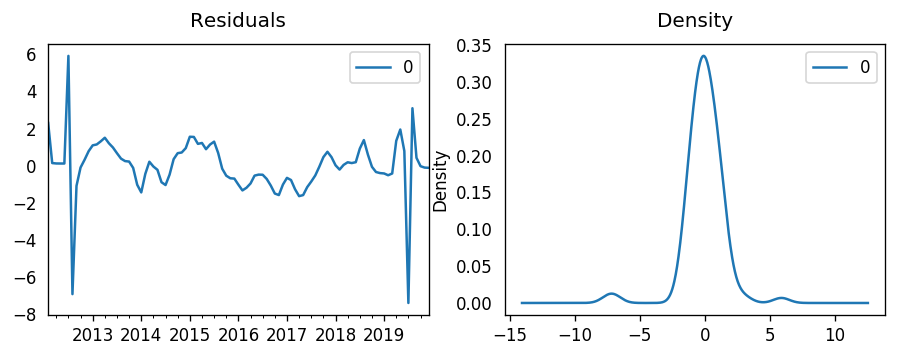

In [186]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])

Why the spikes at the both ends?

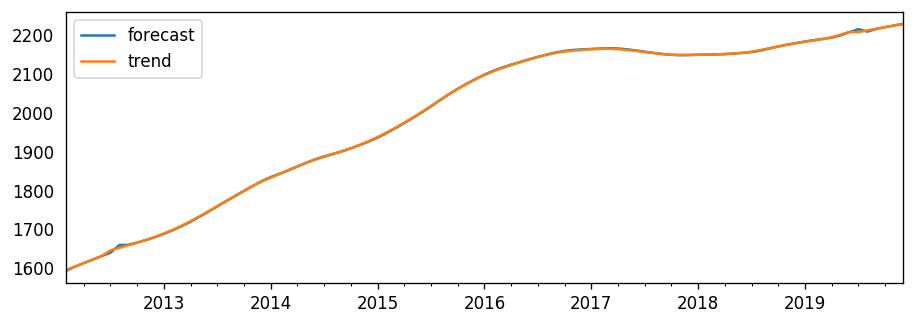

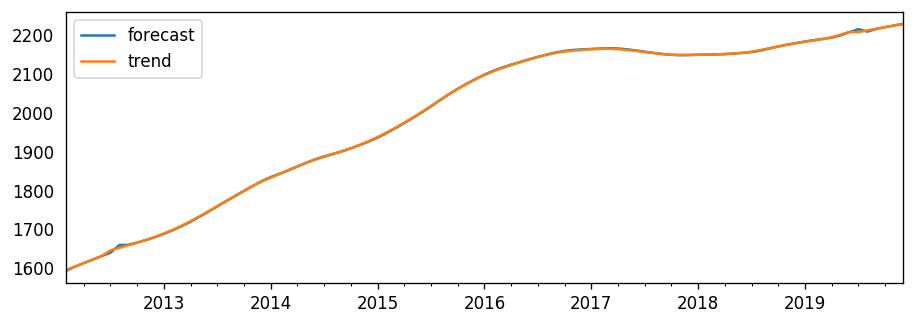

In [187]:
model_fit.plot_predict(dynamic=False)

In [233]:
train = decomp.trend['2012':'2018']
test = decomp.trend['2019':'2019']

                             ARIMA Model Results                              
Dep. Variable:                D.trend   No. Observations:                   83
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -140.946
Method:                       css-mle   S.D. of innovations              1.302
Date:                Sun, 22 Mar 2020   AIC                            287.893
Time:                        12:07:26   BIC                            295.149
Sample:                    02-01-2012   HQIC                           290.808
                         - 12-01-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             6.9195      2.802      2.469      0.014       1.427      12.412
ar.L1.D.trend     0.9592      0.026     37.552      0.000       0.909       1.009
                                    Root

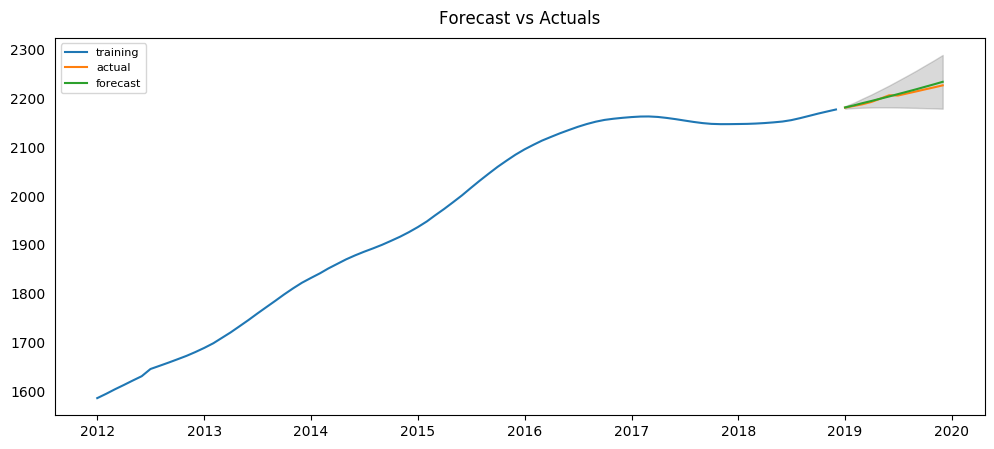

In [234]:
model = ARIMA(train, order=(1, 1, 0),freq='MS')  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(test.shape[0], alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(8,6), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [235]:
mape = np.mean(np.abs(fc_series - test)/np.abs(test))
print(mape)

0.0014256084511769535


In [237]:
# import pmdarima as pm

In [238]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX

In [ ]:
VAR()